In [2]:
import sys
sys.path.append("C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\Tools")
sys.path

['',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\python36.zip',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\DLLs',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages\\cycler-0.10.0-py3.6.egg',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\houxi\\.ipython',
 'C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\\Tools']

In [3]:
import sqlite3
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn import model_selection

from toolbox_02450 import clusterplot

from matplotlib.pyplot import figure, plot, legend, xlabel, show,annotate
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

C:\WorkingGround\Anaconda\envs\ipykernel_py3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
db_location = "soccer/database.sqlite"

conn = sqlite3.connect(db_location)

In [5]:
df_teams_attrs = pd.read_sql(sql="SELECT * FROM Team_Attributes WHERE date == '2015-09-10 00:00:00'", con=conn)
df_teams_names = pd.read_sql(sql="SELECT * FROM Team", con=conn)
df_teams_attrs=df_teams_attrs.dropna()
df_teams_names=df_teams_names.dropna()
df_teams_merged = pd.merge(df_teams_attrs, df_teams_names, how='inner', on=['team_fifa_api_id'],suffixes=['','_y'])
df_teams_merged.drop(list(df_teams_merged.filter(regex = '_y')), axis = 1, inplace = True)
df_teams_merged.drop(list(df_teams_merged.filter(regex = 'id')), axis = 1, inplace = True)
df_teams_merged.drop('date', axis = 1, inplace = True)
df_teams_merged=df_teams_merged.dropna()
print ("all columns ",df_teams_merged.columns)
df_teams_merged.head()

all columns  Index(['buildUpPlaySpeed', 'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceDefenderLineClass', 'team_long_name', 'team_short_name'],
      dtype='object')


,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceDefenderLineClass,team_long_name,team_short_name
0,47,Balanced,41,Normal,54,Mixed,Organised,54,Normal,63,...,64,Normal,Organised,47,Medium,44,Press,Cover,FC Aarau,AAR
1,59,Balanced,64,Normal,53,Mixed,Organised,51,Normal,72,...,63,Normal,Free Form,49,Medium,45,Press,Cover,Aberdeen,ABE
2,59,Balanced,57,Normal,52,Mixed,Organised,48,Normal,38,...,52,Normal,Organised,38,Medium,47,Press,Cover,AC Ajaccio,AJA
3,48,Balanced,70,Lots,52,Mixed,Organised,66,Normal,36,...,69,Lots,Organised,58,Medium,57,Press,Cover,Milan,ACM
4,53,Balanced,53,Normal,44,Mixed,Organised,55,Normal,51,...,60,Normal,Organised,39,Medium,38,Press,Cover,Académica de Coimbra,ACA


In [6]:
conn.close()

In [7]:
class_columns=['buildUpPlaySpeedClass','buildUpPlayDribblingClass','buildUpPlayPassingClass','buildUpPlayPositioningClass','chanceCreationPassingClass',
              'chanceCreationCrossingClass','chanceCreationShootingClass','chanceCreationPositioningClass','defencePressureClass','defenceAggressionClass'
              ,'defenceDefenderLineClass']  ##all ordinal features

exclude_columns= class_columns + ['team_long_name','team_short_name']

classes_dict=dict()
for class_column in class_columns:
    uniq_classess=df_teams_merged[class_column].unique().tolist()
    uniq_values=range(1,len(uniq_classess)+1)
    #for uniq_class, uniq_vlaue in zip(uniq_classess,uniq_values):
    #    df_teams_merged[class_column].replace({uniq_class: uniq_vlaue},inplace=True)
    
    classes_dict[class_column]=zip(uniq_classess,uniq_values)
    print ("Map classes ", uniq_classess , "from column ",class_column , ' to numerics ',uniq_values)
df_teams_merged.head()

Map classes  ['Balanced', 'Fast', 'Slow'] from column  buildUpPlaySpeedClass  to numerics  range(1, 4)
Map classes  ['Normal', 'Lots', 'Little'] from column  buildUpPlayDribblingClass  to numerics  range(1, 4)
Map classes  ['Mixed', 'Short', 'Long'] from column  buildUpPlayPassingClass  to numerics  range(1, 4)
Map classes  ['Organised', 'Free Form'] from column  buildUpPlayPositioningClass  to numerics  range(1, 3)
Map classes  ['Normal', 'Safe', 'Risky'] from column  chanceCreationPassingClass  to numerics  range(1, 4)
Map classes  ['Normal', 'Lots', 'Little'] from column  chanceCreationCrossingClass  to numerics  range(1, 4)
Map classes  ['Normal', 'Lots', 'Little'] from column  chanceCreationShootingClass  to numerics  range(1, 4)
Map classes  ['Organised', 'Free Form'] from column  chanceCreationPositioningClass  to numerics  range(1, 3)
Map classes  ['Medium', 'High', 'Deep'] from column  defencePressureClass  to numerics  range(1, 4)
Map classes  ['Press', 'Double', 'Contain'] f

,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceDefenderLineClass,team_long_name,team_short_name
0,47,Balanced,41,Normal,54,Mixed,Organised,54,Normal,63,...,64,Normal,Organised,47,Medium,44,Press,Cover,FC Aarau,AAR
1,59,Balanced,64,Normal,53,Mixed,Organised,51,Normal,72,...,63,Normal,Free Form,49,Medium,45,Press,Cover,Aberdeen,ABE
2,59,Balanced,57,Normal,52,Mixed,Organised,48,Normal,38,...,52,Normal,Organised,38,Medium,47,Press,Cover,AC Ajaccio,AJA
3,48,Balanced,70,Lots,52,Mixed,Organised,66,Normal,36,...,69,Lots,Organised,58,Medium,57,Press,Cover,Milan,ACM
4,53,Balanced,53,Normal,44,Mixed,Organised,55,Normal,51,...,60,Normal,Organised,39,Medium,38,Press,Cover,Académica de Coimbra,ACA


In [8]:
df_teams_features = df_teams_merged[list(set(df_teams_merged.columns.values.tolist()) - set(exclude_columns))]
df_teams_classes = df_teams_merged[class_columns]
teams_names_list=df_teams_merged['team_long_name'].values.tolist()

In [9]:
X=df_teams_features[[ 'buildUpPlaySpeed', 'buildUpPlayPassing']].as_matrix()
y=df_teams_classes['buildUpPlaySpeedClass'].as_matrix()
print ("all selected team features ",df_teams_features.columns)

all selected team features  Index(['buildUpPlayPassing', 'buildUpPlayDribbling', 'chanceCreationPassing',
       'chanceCreationShooting', 'chanceCreationCrossing', 'defencePressure',
       'buildUpPlaySpeed', 'defenceAggression'],
      dtype='object')


### 1. Cluster Data by GMM and use cross-validation to estimate the number of components in the GMM. Interpret the extracted cluster centers

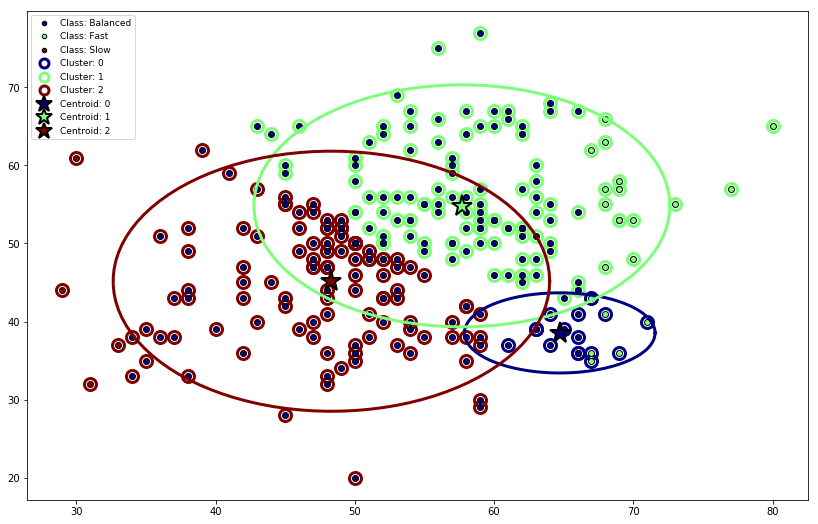

In [10]:
N, M = X.shape
K=3
cov_type = 'diag'       
# type of covariance, you can try out 'diag' as well
reps = 1                
# number of fits with different initalizations, best result will be kept
# Fit Gaussian mixture model
gmm = GaussianMixture(n_components=K, covariance_type=cov_type, n_init=reps).fit(X)
cls = gmm.predict(X)    
# extract cluster labels
cds = gmm.means_        
# extract cluster centroids (means of gaussians)
covs = gmm.covariances_
# extract cluster shapes (covariances of gaussians)
if cov_type == 'diag':    
    new_covs = np.zeros([K,M,M])    

count = 0    
for elem in covs:        
    temp_m = np.zeros([M,M])        
    for i in range(len(elem)):            
        temp_m[i][i] = elem[i]        
    
    new_covs[count] = temp_m        
    count += 1
        
covs = new_covs
# Plot results:
figure(figsize=(14,9))

clusterplot(X, clusterid=cls, centroids=cds, y=y, covars=covs)
show()

Fitting model for K=1
Fitting model for K=2
Fitting model for K=3
Fitting model for K=4
Fitting model for K=5
Fitting model for K=6
Fitting model for K=7
Fitting model for K=8
Fitting model for K=9
Fitting model for K=10


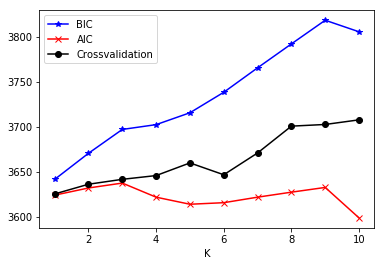

BIC, AIC TEST


In [11]:

N, M = X.shape

# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'full'     # you can try out 'diag' as well
reps = 3                # number of fits with different initalizations, best result will be kept

# Allocate variables
BIC = np.zeros((T,))
AIC = np.zeros((T,))
CVE = np.zeros((T,))

# K-fold crossvalidation
CV = model_selection.KFold(n_splits=10,shuffle=True)

for t,K in enumerate(KRange):
        print('Fitting model for K={0}'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X)

        # Get BIC and AIC
        BIC[t,] = gmm.bic(X)
        AIC[t,] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV.split(X):

            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X_train)

            # compute negative log likelihood of X_test
            CVE[t] += -gmm.score_samples(X_test).sum()
            

# Plot results

figure(1); 
plot(KRange, BIC,'-*b')
plot(KRange, AIC,'-xr')
plot(KRange, 2*CVE,'-ok')
legend(['BIC', 'AIC', 'Crossvalidation'])
xlabel('K')
show()

print('BIC, AIC TEST')